## Análisis de resultados del modelo BETO

Objetivo:
Profundizar en el rendimiento de BETO, tanto en el conjunto de prueba interno (Fold 4) como en el hold-out humano, y extraer conclusiones sobre sus fortalezas y limitaciones.


1. Cabecera

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Mapa de etiquetas:

In [2]:
id2label = {
    0: "ad_hominem",
    1: "framing_binario",
    2: "logos",
    3: "retorica_vacia",
}
label2id = {v: k for k, v in id2label.items()}
id2label


{0: 'ad_hominem', 1: 'framing_binario', 2: 'logos', 3: 'retorica_vacia'}

2. Cargar modelo final

In [3]:
MODEL_DIR = "./models/beto_v3_final_fold0"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

print("Modelo cargado desde:", MODEL_DIR)


Modelo cargado desde: ./models/beto_v3_final_fold0


3. Cargar dataset con folds y extraer Fold 4

In [4]:
PATH_FOLDS = "../data/processed/clean_v2/folds/corpus_clean_v2_folds.csv"
df_full = pd.read_csv(PATH_FOLDS)

df_full.head()


,text,labels,group_id,fold
0,Habla de verdad y solo cuenta su parte,0,3026b3a2a78a2b7c351ce65e1c8a1aea,2
1,La fuerza del pueblo es más fuerte que cualqui...,3,584e534c015f8b6bd23d2d3b57d74283,1
2,Más del 60 % de los empleos creados en pandemi...,2,ba640e8244144484ba43f58ba7b84688,1
3,No hay fuerza más grande que la esperanza,3,deb5caa3e7be895393e0b2e0be670727,0
4,Se llena la boca de patria y vacía los bolsill...,0,261fc2fef1f426ea0a7a90e882286225,2


Suponiendo columnas text, labels, fold:

In [5]:
TEST_FOLD = 4

df_test = df_full[df_full["fold"] == TEST_FOLD].reset_index(drop=True)
print("Tamaño test Fold 4:", len(df_test))
df_test[["text", "labels", "fold"]].head()


Tamaño test Fold 4: 198


,text,labels,fold
0,Más de 50 000 escolares abandonaron clases tra...,2,4
1,El 45 % de los jóvenes peruanos trabaja sin co...,2,4
2,[ADVERSARIO] almuerzan en restaurantes de lujo...,1,4
3,"[ADVERSARIO] nos dividen, [PARTIDO] seguimos r...",1,4
4,"[PARTIDO] ponemos los votos, [ADVERSARIO] pone...",1,4


4. Función predict_batch (misma idea que en el 5)

In [6]:
def predict_batch(texts, batch_size=32):
    all_pred_ids = []
    all_probs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        pred_ids = np.argmax(probs, axis=1)
        all_pred_ids.extend(pred_ids.tolist())
        all_probs.append(probs)

    all_probs = np.vstack(all_probs)
    pred_labels = [id2label[int(i)] for i in all_pred_ids]
    return np.array(all_pred_ids), pred_labels, all_probs


5. Predicciones para Fold 4 + métricas

In [7]:
texts_test = df_test["text"].tolist()
true_ids_test = df_test["labels"].tolist()

pred_ids_test, pred_labels_test, probs_test = predict_batch(texts_test, batch_size=32)

df_test_pred = df_test.copy()
df_test_pred["true_label_id"] = true_ids_test
df_test_pred["true_label_name"] = df_test_pred["labels"].map(id2label)
df_test_pred["pred_label_id"] = pred_ids_test
df_test_pred["pred_label_name"] = pred_labels_test

df_test_pred[["text", "true_label_name", "pred_label_name"]].head()


,text,true_label_name,pred_label_name
0,Más de 50 000 escolares abandonaron clases tra...,logos,logos
1,El 45 % de los jóvenes peruanos trabaja sin co...,logos,logos
2,[ADVERSARIO] almuerzan en restaurantes de lujo...,framing_binario,framing_binario
3,"[ADVERSARIO] nos dividen, [PARTIDO] seguimos r...",framing_binario,framing_binario
4,"[PARTIDO] ponemos los votos, [ADVERSARIO] pone...",framing_binario,framing_binario


Métricas:

In [8]:
target_names = [id2label[i] for i in sorted(id2label)]
print(classification_report(true_ids_test, pred_ids_test, target_names=target_names))


                 precision    recall  f1-score   support

     ad_hominem       1.00      1.00      1.00        46
framing_binario       1.00      1.00      1.00        57
          logos       1.00      1.00      1.00        51
 retorica_vacia       1.00      1.00      1.00        44

       accuracy                           1.00       198
      macro avg       1.00      1.00      1.00       198
   weighted avg       1.00      1.00      1.00       198



Matriz de confusión:

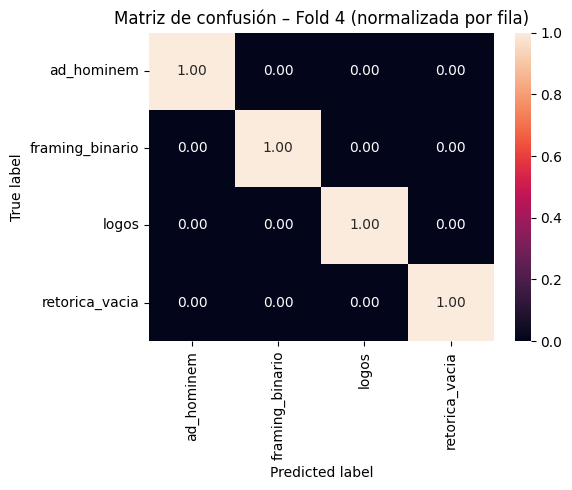

In [9]:
labels_sorted = sorted(id2label.keys())
cm = confusion_matrix(true_ids_test, pred_ids_test, labels=labels_sorted)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    xticklabels=[id2label[i] for i in labels_sorted],
    yticklabels=[id2label[i] for i in labels_sorted],
    cbar=True,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Matriz de confusión – Fold 4 (normalizada por fila)")
plt.tight_layout()
plt.show()


6. Errores y slices (lo de siempre)

In [10]:
errores_f4 = df_test_pred[df_test_pred["true_label_id"] != df_test_pred["pred_label_id"]].copy()
print("Número de errores en Fold 4:", len(errores_f4))
errores_f4[["text", "true_label_name", "pred_label_name"]].head(20)


Número de errores en Fold 4: 0


,text,true_label_name,pred_label_name


Pares de confusión:

In [11]:
confusiones_pares = (
    errores_f4.groupby(["true_label_name", "pred_label_name"])
    .size()
    .reset_index(name="num")
    .sort_values("num", ascending=False)
)
confusiones_pares


,true_label_name,pred_label_name,num


In [12]:
len(errores_f4), errores_f4.head()


(0,
 Empty DataFrame
 Columns: [text, labels, group_id, fold, true_label_id, true_label_name, pred_label_id, pred_label_name]
 Index: [])

Evaluación y análisis de resultados del modelo BETO en el conjunto de prueba (Fold 4)

In [13]:
df_holdout = pd.read_csv("../data/holdout_humano.csv")
texts_h = df_holdout["text"].tolist()
true_ids_h = df_holdout["label"].tolist()

pred_ids_h, pred_labels_h, probs_h = predict_batch(texts_h)

df_holdout["true_label_id"] = true_ids_h
df_holdout["true_label_name"] = df_holdout["label_name"]
df_holdout["pred_label_id"] = pred_ids_h
df_holdout["pred_label_name"] = pred_labels_h

errores_h = df_holdout[df_holdout["true_label_id"] != df_holdout["pred_label_id"]]
errores_h[["text", "true_label_name", "pred_label_name"]]


,text,true_label_name,pred_label_name
1,"Quieren destruir el país, nosotros vamos a res...",framing_binario,retorica_vacia
3,"Promete cambio, pero no explica cómo lo hará",retorica_vacia,ad_hominem


## 5. Discusión y conclusiones parciales

En el conjunto de prueba interno (Fold 4) el modelo BETO alcanzó una exactitud del 100 %, con una matriz de
confusión perfectamente diagonal. Esto indica que, dado el esquema de partición propuesto (folds estratificados
por grupos), el modelo es capaz de distinguir sin errores las cuatro categorías retóricas en ese subconjunto.

Sin embargo, al evaluar en el conjunto externo (hold-out humano), construido con frases inéditas redactadas por el
autor, aparecen dos errores de clasificación:

1. **framing_binario → retorica_vacia** en la frase  
   *"Quieren destruir el país, nosotros vamos a rescatarlo"*.  
   Se trata de un enunciado polarizante (ellos vs nosotros) pero también formulado como eslogan vacío, lo que
   explica que el modelo lo asocie a retórica vacía.

2. **retorica_vacia → ad_hominem** en la frase  
   *"Promete cambio, pero no explica cómo lo hará"*.  
   Aquí el modelo interpreta la crítica a la falta de sustento como un ataque personal al político, por lo que
   la aproxima a la categoría ad hominem.

Estas confusiones muestran que las fronteras entre *framing binario*, *retórica vacía* y *ad hominem* no siempre
son nítidas, ni para los humanos ni para el modelo. Aun así, el número total de errores en el hold-out es muy bajo,
lo que sugiere que BETO generaliza adecuadamente más allá del corpus de entrenamiento.
